In [2]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
     ---------------------------------------- 0.0/108.7 kB ? eta -:--:--
     --- ------------------------------------ 10.2/108.7 kB ? eta -:--:--
     ------------- ----------------------- 41.0/108.7 kB 653.6 kB/s eta 0:00:01
     -------------------------------------- 108.7/108.7 kB 1.0 MB/s eta 0:00:00
  Using cached kiwisolver-1.4.8-cp312-cp312-win_amd64.whl.metadata (6.3 kB)
   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   - -------------------------------------- 0.3/8.1 MB 10.6 MB/s eta 0:00:01
   ------- -------------------------------- 1.5/8.1 MB 18.6 MB/s eta 0:00:01
   ------------- -------------------------- 2.8/8.1 MB 22.0 MB/s eta 0:00:01
   ------------------------ --------------- 5.0/8.1 MB 26.7 MB/s eta 0:00:01
   ----------------------------- ---------- 6.0/8.1 MB 25.4 MB/s eta 0:00:01
   ------------------------------


[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
import wave
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
#from scipy.signal import find_peaks
from IPython.display import Audio

### MAIN CODIGO

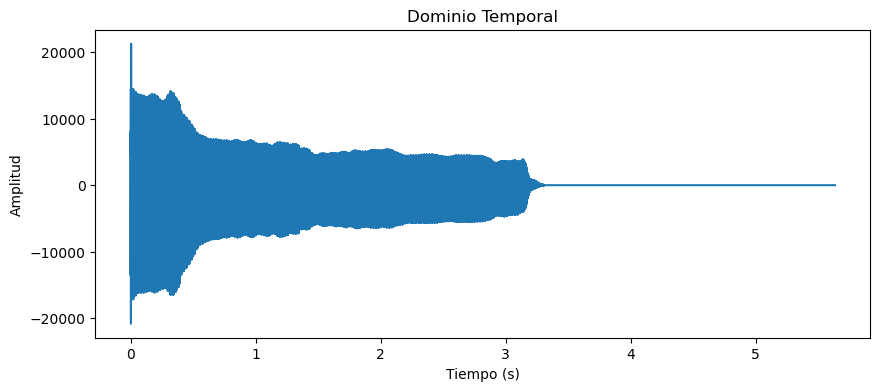

In [53]:
pintar_tiempo(matriz_senales, 17, 124252,22050)


In [101]:
def pintar_freq(freq,ticks_frecuencia,j,fft_values):    
    margen = ticks_frecuencia[-1]
    plt.figure(figsize=(8, 4))
    plt.plot(freq,20 * np.log10(fft_values))
   
    plt.xticks(ticks_frecuencia)

    plt.title(f"Espectro de frecuencia Clarinete")#del audio {j}")
    plt.xlabel("Frecuencia (Hz)")
    plt.ylabel("Magnitud")
    plt.xlim(0, margen + 50)  # Opcional: rate/2 : mostrar solo la mitad positiva
    plt.grid(True)
    plt.show()

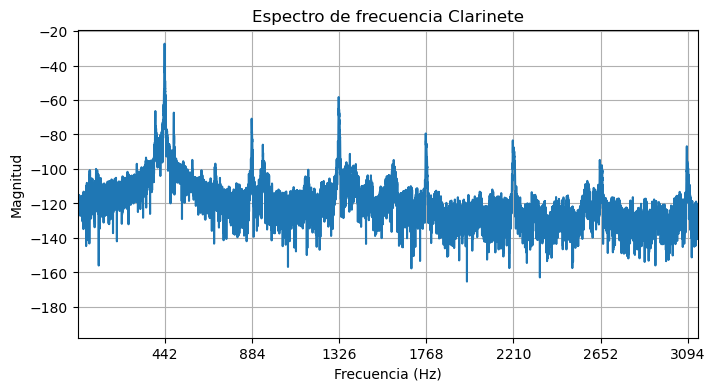

In [102]:
i = 95

freq, fft_values = calcular_fft(matriz_senales[i], rate)
    # Normalizar la señal
fft_values = fft_values/fft_values.sum()
#if i == 135:
pintar_freq(freq,ticks_frecuencia,i,fft_values)


In [65]:
def pintar_freq(freq,ticks_frecuencia,j,fft_values):    
    margen = ticks_frecuencia[-1]
    plt.figure(figsize=(8, 4))
    plt.plot(freq,20 * np.log10(fft_values))
   
    plt.xticks(ticks_frecuencia)

    plt.title(f"Espectro de frecuencia Piano")#del audio {j}")
    plt.xlabel("Frecuencia (Hz)")
    plt.ylabel("Magnitud")
    plt.xlim(0, margen + 50)  # Opcional: rate/2 : mostrar solo la mitad positiva
    plt.grid(True)
    plt.show()

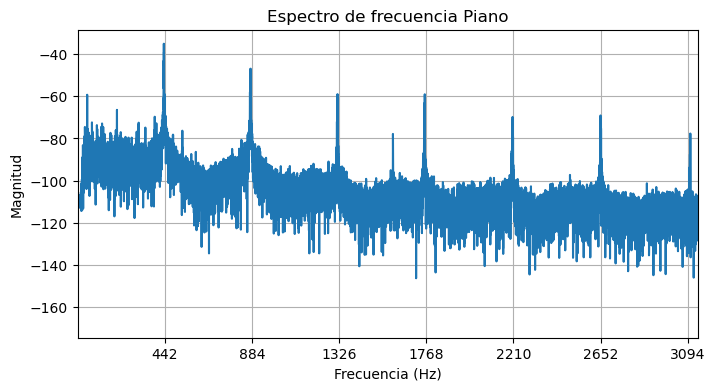

In [66]:
i = 200
freq, fft_values = calcular_fft(matriz_senales[i], rate)
    # Normalizar la señal
fft_values = fft_values/fft_values.sum()
#if i == 135:
pintar_freq(freq,ticks_frecuencia,i,fft_values)

In [2]:
# MÓDULO DE TODAS LAS FUNCIONES
def escuchar(i):
    display(Audio(dataset.loc[i,'Path'],autoplay = True))
    return

# Función para calcular el espectro de frecuencia usando FFT y fftshift
def calcular_fft(signal, rate):
    window = np.hanning(len(signal))
    signal_windowed = signal * window
    n = len(signal)
    freq = np.fft.fftshift(np.fft.fftfreq(n, d=1/rate))
    fft_values = np.fft.fftshift(np.abs(np.fft.fft(signal_windowed)))
    return freq, fft_values

# Función para cargar los datos de un archivo .wav
def cargar_audio(audio_path):
    with wave.open(audio_path, 'r') as wav_file:
        n_frames = wav_file.getnframes()
        n_channels = wav_file.getnchannels()
        rate = wav_file.getframerate()
        
        # Leer la señal del archivo
        signal = wav_file.readframes(n_frames)
        signal = np.frombuffer(signal, dtype=np.int16)
        
        if n_channels == 2:  # Convertir a mono si hay 2 canales
            signal = signal.reshape(-1, 2)
            signal = signal.mean(axis=1)
    return signal, rate

def pintar_tiempo(matriz_senales,i,len_signal,rate):
    time = np.linspace(0, len_signal / rate, len_signal)
    signal = matriz_senales[i,:len_signal]
    plt.figure(figsize=(10, 4))
    plt.plot(time, signal)
    plt.title(f'Dominio Temporal')#: Audio {i+1}')
    plt.xlabel('Tiempo (s)')
    plt.ylabel('Amplitud')
    plt.show()

def frecuencia_buscada(f,freq,rate):
    return int(np.size(freq) / 2 + f /( rate / np.size(freq)))

def encontrar_indice_maximo_local(freq,fft_values,frecuencia,rate, tol=50):
    np.argmax(fft_values[frecuencia_buscada(frecuencia,freq,rate)-tol:frecuencia_buscada(frecuencia,freq,rate)+tol])
    return frecuencia_buscada(frecuencia,freq,rate) - tol + np.argmax(fft_values[frecuencia_buscada(frecuencia,freq,rate)-tol:frecuencia_buscada(frecuencia,freq,rate)+tol])

def construir_vector_alpha_no_norm(freq,fft_values,ticks_frecuencia,rate):
    lista = np.zeros(len(ticks_frecuencia))
    for i in np.arange(len(ticks_frecuencia)):
        lista[i]=(20 * np.log10(fft_values[encontrar_indice_maximo_local(freq,fft_values,ticks_frecuencia[i],rate)]))
        lista[i]=((fft_values[encontrar_indice_maximo_local(freq,fft_values,ticks_frecuencia[i],rate)]))
    return lista

def alpha_a_voltios_rms(alpha):
    for i in np.arange(len(alpha)):
        alpha[i:] = 10**(alpha[i]/20)

def construir_vector_alpha(alpha_no_norm):
    cuadrado = [i**2 for i in alpha_no_norm]
    vector = alpha_no_norm/np.sqrt(np.sum(cuadrado))
    return vector

def pintar_freq(freq,ticks_frecuencia,j,fft_values):    
    margen = ticks_frecuencia[-1]
    plt.figure(figsize=(8, 4))
    plt.plot(freq,20 * np.log10(fft_values))
    for i in np.arange(len(ticks_frecuencia)):
        m = int(encontrar_indice_maximo_local(freq,fft_values,ticks_frecuencia[i],22050))
        #print(m)
        
        plt.plot([freq[m]],20 * np.log10(fft_values[encontrar_indice_maximo_local(freq,fft_values,ticks_frecuencia[i],22050)]),'ro')
        plt.plot([ticks_frecuencia[i]],20 * np.log10(fft_values[frecuencia_buscada(ticks_frecuencia[i],freq,22050)]),'yo')
        #plt.plot([ticks_frecuencia[i]],20 * np.log10(fft_values[encontrar_indice_maximo_local(freq,fft_values,ticks_frecuencia[i],22050)]),'ro')
    plt.xticks(ticks_frecuencia)

    plt.title(f"Espectro de frecuencia del audio {j}")
    plt.xlabel("Frecuencia (Hz)")
    plt.ylabel("Magnitud")
    plt.xlim(0, margen + 50)  # Opcional: rate/2 : mostrar solo la mitad positiva
    plt.grid(True)
    plt.show()

def pintar_frec(freq,i,fft_values):
    plt.figure(figsize=(10, 4))
    plt.plot(freq[int(len(freq)/2):], 20 * np.log10(fft_values[int(len(freq)/2):]))  # Amplitud en dB
    plt.title(f'Dominio de Frecuencia : Audio {i+1}')
    plt.xlabel('Frecuencia (Hz)')
    plt.ylabel('Amplitud (dB)')
    plt.show()

def pintar_frec_norm(freq,i,amplitudes_db,features):
    plt.figure(figsize=(10, 4))
    plt.plot(freq, amplitudes_db)  # Amplitud en dB
    plt.title(f'Dominio de Frecuencia (Normalizado): Audio {i}')
    plt.xlim(0,max(ticks_frecuencia)+150)
    plt.xticks(ticks_frecuencia)
    plt.yticks(features)
    plt.xlabel('Frecuencia (Hz)')
    plt.ylabel('Amplitud (dB)')
    plt.grid()
    plt.show()

def indice_frecuencia(frecuencia,amplitudes_db,rate):
    #
    # Devuelve el índice en el array freq en el que se encuentra la frecuencia para cada señal
    #
    return int(len(amplitudes_db)*frecuencia/rate*2)

def evaluar_maximo_interv(f_obj,amplitudes_db,tol):
    pico=np.argmax(amplitudes_db[f_obj-tol:f_obj+tol])
    #corrección del pico teoria-practica
    pico = f_obj + pico -tol-1
    return amplitudes_db[pico]

def etiquetar(data):
    y = np.array(data['Instrument (in full)']) # Etiquetas
    y = np.zeros(len(data),dtype=int)
    # Poner las etiquetas
    for i in np.arange(len(data)): 
        if np.array(data['Instrument (in full)'][i])=='Saxofon_Alto':
            y[i] = 0
        elif np.array(data['Instrument (in full)'][i])=='Clarinete':
            y[i] = 1
        elif np.array(data['Instrument (in full)'][i])=='Piano':
            y[i] = 2
        else :
            y[i] = 3
    return y

# Función Softmax
def softmax(z):
    exp_z = np.exp(z) 
    return exp_z / np.sum(exp_z, axis=0)

# Función Sigmoide
def sigmoid(z):
    return 1 / (1 + np.exp(-z))


In [ ]:
i = 135
rate = 22050
len_signal = len(matriz_senales[i])
time = np.linspace(0, len_signal / rate, len_signal)
signal = matriz_senales[i,:len_signal]
plt.figure(figsize=(10, 4))
plt.plot(time[154:3000], signal[154:3000])
plt.title(f'Audio en el dominio del tiempo')
#plt.title(f'Dominio Temporal: Audio {i+1}')
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.show()

In [5]:
dataset = 'base_de_datos.csv'
data = pd.read_csv(dataset)

# Variables globales
num_armonicos = 2
tol = 50

ticks_frecuencia = []
for i in range(num_armonicos):
    ticks_frecuencia.append(221*(2*(i+1)))

# Matriz para almacenar todas las señales
n_audios = len(data)
longitud_maxima = 0  # Para determinar la longitud máxima de las señales


# Función para cargar los datos de un archivo .wav
def cargar_audio(audio_path):
    with wave.open(audio_path, 'r') as wav_file:
        n_frames = wav_file.getnframes()
        n_channels = wav_file.getnchannels()
        rate = wav_file.getframerate()
        
        # Leer la señal del archivo
        signal = wav_file.readframes(n_frames)
        signal = np.frombuffer(signal, dtype=np.int16)
        
        if n_channels == 2:  # Convertir a mono si hay 2 canales
            signal = signal.reshape(-1, 2)
            signal = signal.mean(axis=1)
    return signal, rate


# Primera pasada para calcular la longitud máxima
for audio_path in data['Path']:
    signal, _ = cargar_audio(audio_path)
    longitud_maxima = max(longitud_maxima, len(signal))

# Crear una matriz para almacenar las señales con padding
matriz_senales = np.zeros((n_audios, longitud_maxima))

alpha = np.zeros((len(data),len(ticks_frecuencia)))
# Segunda pasada para cargar las señales y almacenarlas en la matriz
for i, audio_path in enumerate(data['Path'][:]):
    signal, rate = cargar_audio(audio_path)
    matriz_senales[i, :len(signal)] = signal


    signal = signal/sum(signal)


    if i == 1035:
        plt.figure(figsize=(10, 4))
        plt.plot(freq[int(len(freq)/2):], (fft_values[int(len(freq)/2):]))  # Amplitud en dB
        plt.title(f'Dominio de Frecuencia')
        plt.xlabel('Frecuencia (Hz)')
        plt.ylabel('Amplitud ')
        plt.show()
    # Calcular el espectro en frecuencia
    freq, fft_values = calcular_fft(matriz_senales[i], rate)
     # Normalizar la señal
    fft_values = fft_values/fft_values.sum()
    #if i == 135:
    #pintar_freq(freq,ticks_frecuencia,i,fft_values)
    alpha_no_norm = np.zeros(len(ticks_frecuencia))
    
    alpha_no_norm = construir_vector_alpha_no_norm(freq,fft_values,ticks_frecuencia,rate)
    alpha[i] = construir_vector_alpha(alpha_no_norm)
    assert np.abs(np.sum(alpha[i]**2)-1)<1e6

y = etiquetar(data)

C:\Users\USUARIO\AppData\Local\Temp\ipykernel_23924\2190164494.py:49: RuntimeWarning: overflow encountered in scalar add
  signal = signal/sum(signal)


In [105]:
ALPHA = alpha

In [ ]:
X = np.array(alpha) # Matriz de entrada al clasificador
print("Características (X) shape:", X.shape)
print("Etiquetas (y) shape:", y.shape)

In [ ]:
numero_clases = np.unique(y)
print(numero_clases)

In [18]:
len(matriz_senales[5])

124252

Point [0.99864719 0.05187146 0.00342762] does not lie on the unit sphere
Point [0.99960282 0.02796611 0.00342473] does not lie on the unit sphere
Point [0.99886614 0.04727922 0.00538441] does not lie on the unit sphere
Point [0.99995252 0.00684946 0.0067137 ] does not lie on the unit sphere
Point [0.99099536 0.13244592 0.01952607] does not lie on the unit sphere
Point [0.99957151 0.02912245 0.0012522 ] does not lie on the unit sphere
Point [0.99715248 0.07492998 0.00821447] does not lie on the unit sphere
Point [0.99952909 0.03064379 0.00130207] does not lie on the unit sphere
Point [0.87567525 0.48200888 0.02928539] does not lie on the unit sphere
Point [0.999802   0.00306303 0.01948646] does not lie on the unit sphere
Point [0.87567525 0.48200888 0.02928539] does not lie on the unit sphere
Point [0.99715248 0.07492998 0.00821447] does not lie on the unit sphere
Point [0.99862019 0.05184931 0.00783478] does not lie on the unit sphere
Point [0.99715248 0.07492998 0.00821447] does not l

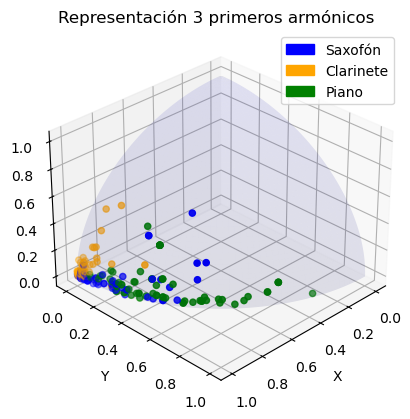

In [109]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# Verify that each point lies on the unit sphere
for point in alpha:
    x, c, z = point
    assert np.isclose(x**2 + c**2 + z**2, 1), f"Point {point} does not lie on the unit sphere"

# Extract x, y, z coordinates from data points
x_coords = [point[0] for point in alpha]
y_coords = [point[1] for point in alpha]
z_coords = [point[2] for point in alpha]

# Colores para cada clase (puedes personalizarlos)
colores = ['b', 'orange', 'g', 'm']  # rojo, verde, azul, magenta
#colores = {0: 'r', 1: 'g', 2: 'b', 3: 'orange'}


# Asigna color a cada punto según su etiqueta
colores_por_punto = [colores[int(label)] for label in y]

# Crea la figura 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

#for clase in np.unique(y):
#    indices = np.where(y == clase)
#    ax.scatter(
#        x_coords[indices], y_coords[indices], z_coords[indices],
#        c=colores[clase], label=etiquetas[clase], s=40
#    )

# Dibuja los puntos con su color correspondiente
ax.scatter(x_coords, y_coords, z_coords, c=colores_por_punto, marker='o')


# Plot the unit sphere for reference
u = np.linspace(0, np.pi/2, 100)
v = np.linspace(0, np.pi/2 , 100)
x_sphere = np.outer(np.cos(u), np.sin(v))
y_sphere = np.outer(np.sin(u), np.sin(v))
z_sphere = np.outer(np.ones(np.size(u)), np.cos(v))
ax.plot_surface(x_sphere, y_sphere, z_sphere, color='blue', alpha=0.1)

punto_destacado = [0.77962569, 0.40845272, 0.47471061]
#ax.scatter([punto_destacado[0]], [punto_destacado[1]], [punto_destacado[2]], color='r', s=100, label='Punto destacado')  # s=100 para hacerlo más grande

# Set labels
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')


ax.view_init(elev=30, azim=45)  # Puedes ajustar estos valores

from matplotlib.patches import Patch

# Supongamos que usaste estos colores para las clases
colores = {0: 'b', 1: 'orange', 2: 'g', 3: 'm'}
#etiquetas = {0: 'Piano', 1: 'Saxofón ', 2: 'Clarinete'}#, 3: 'Otro'}
etiquetas = {0: 'Saxofón', 1: 'Clarinete', 2: 'Piano'}#, 3: 'Otro'}

# Crear lista de "leyenda manual"
leyenda_manual = [Patch(color=colores[i], label=etiquetas[i]) for i in etiquetas]

# Añadir leyenda manual
ax.legend(handles=leyenda_manual, loc='upper right')

ax.set_title("Representación 3 primeros armónicos")
# Show plot
plt.show()


## Regresion



In [ ]:
Tamaño FFT grande para espectral buena para error pequeño

In [136]:
import numpy as np

# Función sigmoide
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# Función de pérdida logarítmica
def log_loss(y_true, y_pred):
    #return -np.mean(y_true * np.log(y_pred + 1e-15) + (1 - y_true) * np.log(1 - y_pred + 1e-15))
    #return res
    return -np.sum(y_true * np.log(y_pred + 1e-15) + (1 - y_true) * np.log(1 - y_pred + 1e-15))/len(y_true)

#### Comparación saxo clarinete

In [217]:
X = np.array(alpha[:136])
len(X)
np.arange(0,200)[:136]

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135])

In [243]:
np.dot(X_train, weights) + bias  

array([ 1.26083755,  2.44359187,  4.345225  ,  1.04470978,  4.30935763,
        1.41881795, -0.40905336,  3.83033076,  1.48937217,  1.85846518,
        6.40436108,  1.00528343,  1.32410809, -0.75308499,  0.83953802,
        1.32410809,  1.82028327,  1.08535207,  0.81022222,  5.50564267,
        0.74871927,  1.22298583,  0.731847  ,  0.75301315,  3.6003673 ,
        1.36078165,  9.3307631 ,  1.85846518,  5.57602291,  3.21350014,
        2.83249532,  1.01040844,  1.7350178 ,  2.29235635,  4.91351863,
        1.04690718,  1.65974418,  3.46217505, -0.79792911,  0.9987421 ,
        0.51322468,  1.41881795,  0.22246434,  1.37225207,  1.84195382,
        1.6140525 ,  2.69685899,  1.43606986,  4.91351863,  0.97997745,
        8.49149013,  1.17639915,  0.51322468,  9.53406717,  0.85235962,
        1.65565005,  1.65974418,  3.44765856,  2.75880333,  0.96237787,
        1.24329393,  1.01040844,  0.51322468,  8.21364602, 10.3037961 ,
        1.85846518,  2.39098766, -0.42762881])

In [250]:
weights

array([-27.36136352,  11.24350007, -20.33497265])

[39 50  0 60 57 54 17 19 26 64  2 13 25 24  9 21 52 61  8 37 29 42  7  5
 31 59 49 20 16  4 43 47 51 55 44 40 63 48 46 14 53  1 45 58 28 30 66  6
 33 65 32 15 67 38 36 41 18 22 12 56 27 35  3 62 34 11 10 23]
Época 99999, Pérdida: 0.4396


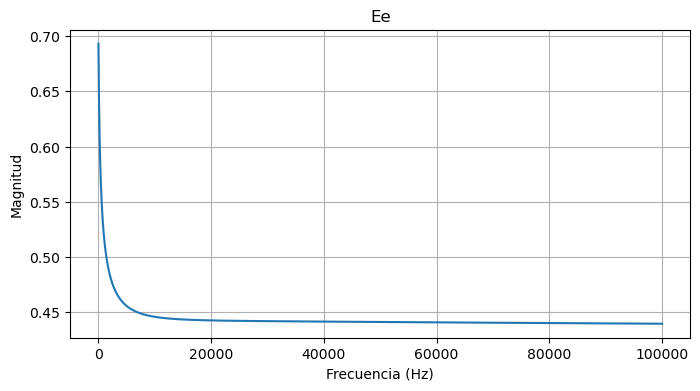

Precisión del clasificador en test: 84.62%
Predicciones en test: Counter({0: 17, 1: 9})
Etiquetas reales: Counter({0: 13, 1: 13})


In [266]:
# Preparar los datos (X = alpha, y = etiquetas binarias: 1 si saxofón, 0 si no)
X = np.array(alpha[:136])
y_all = np.array([1 if label == 0 else 0 for label in y[:136]])

indices = np.arange(68)
np.random.shuffle(indices)  # Mezcla los índices
print(indices)
X[:68] = X[indices]
y_all[:68] = y_all[indices]
X[68:] = X[68+indices]
y_all[68:] = y_all[68+indices]
# 80% entrenamiento, 20% test
split_index = int(0.75 * len(X))
indice_train = 55
split_index = np.concatenate((np.arange(0,indice_train),np.arange(68,68+indice_train)))
index_test = np.concatenate((np.arange(indice_train,68),np.arange(68+indice_train,68*2)))

X_train = X[split_index]
y_train = y_all[split_index]
X_test = X[index_test]
y_test = y_all[index_test]
#
#
indices = np.arange(len(X_train))
np.random.shuffle(indices)  # Mezcla los índices
#print(indices)
# Aplicamos la mezcla a ambos
X_train = X_train[indices]
y_train = y_train[indices]
#
#
indices = np.arange(len(X_test))
np.random.shuffle(indices)  # Mezcla los índices
#print(indices)
#
## Aplicamos la mezcla a ambos
X_test = X_test[indices]
y_test = y_test[indices]
#
# Inicializar pesos y sesgo
weights = np.zeros(X.shape[1])
bias = 0

# Parámetros del modelo
learning_rate = 0.75
epochs = 100000
loss = np.zeros(epochs)

# Entrenamiento
for epoch in range(epochs):
    linear_model = np.dot(X_train, weights) + bias      # z = W*x+b
    y_pred = sigmoid(linear_model)                      # a = g(z)
    
    # Gradientes
    dw = np.dot(X_train.T, (y_pred - y_train)) / y_train.size
    db = np.sum(y_pred - y_train) / y_train.size
    
    # Actualización
    weights -= learning_rate * dw
    bias -= learning_rate * db
    #print(f"y train {epoch}",y_train)
    #print(f"y pred{epoch}",y_pred)
    # Mostrar pérdida
    loss[epoch] = log_loss(y_train,y_pred)
    if epoch - epochs+1 == 0:
        lossy = log_loss(y_train, y_pred)
        print(f'Época {epoch}, Pérdida: {lossy:.4f}')


plt.figure(figsize=(8, 4))
eje = np.arange(epochs)
plt.plot(eje,loss)
plt.title(f"Ee")
plt.xlabel("Frecuencia (Hz)")
plt.ylabel("Magnitud")
plt.grid(True)
plt.show()

def error(loss,i):
    return loss[i-1]-loss[i]

#plt.figure(figsize=(8, 4))
#eje = np.arange(epochs)
#plt.plot(eje[2:],(error(loss,eje[2:])))
##plt.plot(eje[2:],20*np.log10(error(loss,eje[2:])))
#plt.yscale('log')
#plt.title(f"Diferencias entre epocas en log-loss")
#plt.xlabel("Frecuencia (Hz)")
#plt.ylabel("Magnitud")
#plt.grid(True)
#plt.show()

# Evaluación en test
y_pred_test = sigmoid(np.dot(X_test, weights) + bias)
y_pred_class_test = [1 if i > 0.5 else 0 for i in y_pred_test]

accuracy = np.mean(y_pred_class_test == y_test)
print(f'Precisión del clasificador en test: {accuracy * 100:.2f}%')
from collections import Counter
print("Predicciones en test:", Counter(y_pred_class_test))
print("Etiquetas reales:", Counter(y_test))



C:\Users\USUARIO\AppData\Local\Temp\ipykernel_7900\3063727931.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('coolwarm', 2)


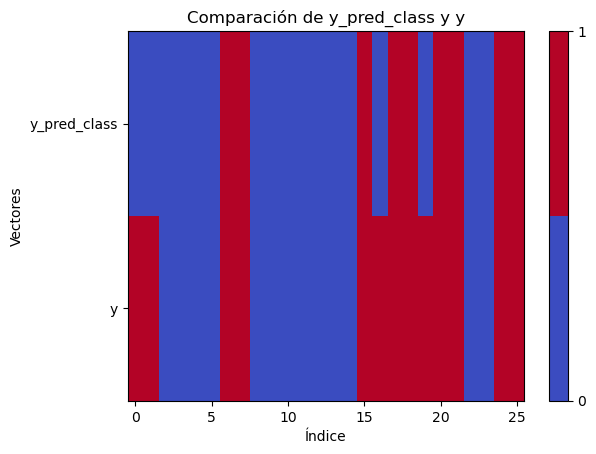

In [264]:
# Crear una cuadrícula para visualizar los vectores
grid = np.zeros((2, len(y_pred_class_test)))

# Asignar los valores a la cuadrícula
grid[0, :] = y_pred_class_test
grid[1, :] = y_test

# Crear un mapa de colores
cmap = plt.cm.get_cmap('coolwarm', 2)

# Graficar la cuadrícula
plt.imshow(grid, cmap=cmap, aspect='auto')

# Etiquetas y título
plt.title('Comparación de y_pred_class y y')
plt.xlabel('Índice')
plt.ylabel('Vectores')
plt.yticks([0, 1], ['y_pred_class', 'y'])

# Barra de color
cbar = plt.colorbar(ticks=[0, 1])
cbar.ax.set_yticklabels(['0', '1'])

# Mostrar la gráfica
plt.show()

In [142]:
68*3

204

### Comparación saxo piano

[43 25 29 21 34  6 11 49 18  1 23 55 35 51 24 31  5 39 61 48 58  7 65  8
 37 46 26  2 44 36 10 13 63 16 52 30 27 56 15  4 42 12 57 54 53 59 67 32
 47 45 33 40 22 64 19  3 14 60 20 62  0 17 38 66  9 28 41 50]
Época 99999, Pérdida: 0.5113


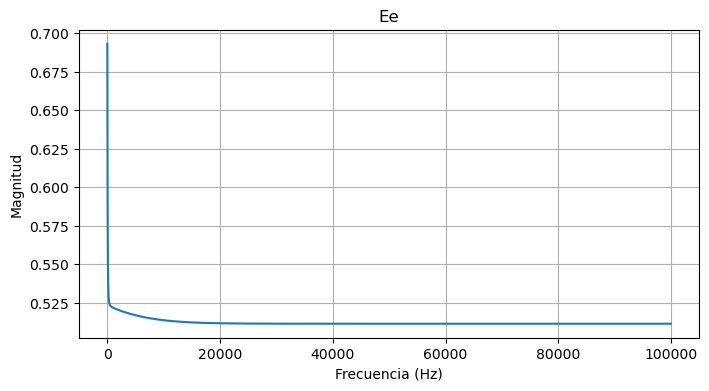

Precisión del clasificador en test: 84.62%
Predicciones en test: Counter({1: 13, 0: 13})
Etiquetas reales: Counter({1: 13, 0: 13})


In [269]:
# Preparar los datos (X = alpha, y = etiquetas binarias: 1 si saxofón, 0 si no)
X = np.concatenate((alpha[:68],alpha[68*2:]))
y_all = np.array([1 if label == 0 else 0 for label in np.concatenate((y[:68], y[68*2:]))])

indices = np.arange(68)
np.random.shuffle(indices)  # Mezcla los índices
print(indices)
X[:68] = X[indices]
y_all[:68] = y_all[indices]
X[68:] = X[68+indices]
y_all[68:] = y_all[68+indices]
# 80% entrenamiento, 20% test
split_index = int(0.75 * len(X))
indice_train = 55
split_index = np.concatenate((np.arange(0,indice_train),np.arange(68,68+indice_train)))
index_test = np.concatenate((np.arange(indice_train,68),np.arange(68+indice_train,68*2)))

X_train = X[split_index]
y_train = y_all[split_index]
X_test = X[index_test]
y_test = y_all[index_test]
#
#
indices = np.arange(len(X_train))
np.random.shuffle(indices)  # Mezcla los índices
#print(indices)
# Aplicamos la mezcla a ambos
X_train = X_train[indices]
y_train = y_train[indices]
#
#
indices = np.arange(len(X_test))
np.random.shuffle(indices)  # Mezcla los índices
#print(indices)
#
## Aplicamos la mezcla a ambos
X_test = X_test[indices]
y_test = y_test[indices]
#
# Inicializar pesos y sesgo
weights = np.zeros(X.shape[1])
bias = 0

# Parámetros del modelo
learning_rate = 0.75
epochs = 100000
loss = np.zeros(epochs)

# Entrenamiento
for epoch in range(epochs):
    linear_model = np.dot(X_train, weights) + bias      # z = W*x+b
    y_pred = sigmoid(linear_model)                      # a = g(z)
    
    # Gradientes
    dw = np.dot(X_train.T, (y_pred - y_train)) / y_train.size
    db = np.sum(y_pred - y_train) / y_train.size
    
    # Actualización
    weights -= learning_rate * dw
    bias -= learning_rate * db
    #print(f"y train {epoch}",y_train)
    #print(f"y pred{epoch}",y_pred)
    # Mostrar pérdida
    loss[epoch] = log_loss(y_train,y_pred)
    if epoch - epochs+1 == 0:
        lossy = log_loss(y_train, y_pred)
        print(f'Época {epoch}, Pérdida: {lossy:.4f}')

def error(loss,i):
    return loss[i-1]-loss[i]

plt.figure(figsize=(8, 4))
eje = np.arange(epochs)
plt.plot(eje,loss)
plt.title(f"Ee")
plt.xlabel("Frecuencia (Hz)")
plt.ylabel("Magnitud")
plt.grid(True)
plt.show()

# Evaluación en test
y_pred_test = sigmoid(np.dot(X_test, weights) + bias)
y_pred_class_test = [1 if i > 0.5 else 0 for i in y_pred_test]

accuracy = np.mean(y_pred_class_test == y_test)
print(f'Precisión del clasificador en test: {accuracy * 100:.2f}%')
from collections import Counter
print("Predicciones en test:", Counter(y_pred_class_test))
print("Etiquetas reales:", Counter(y_test))

C:\Users\USUARIO\AppData\Local\Temp\ipykernel_7900\3063727931.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('coolwarm', 2)


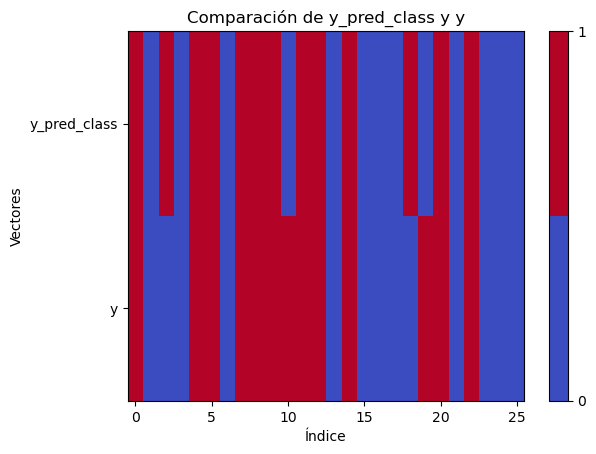

In [270]:
# Crear una cuadrícula para visualizar los vectores
grid = np.zeros((2, len(y_pred_class_test)))

# Asignar los valores a la cuadrícula
grid[0, :] = y_pred_class_test
grid[1, :] = y_test

# Crear un mapa de colores
cmap = plt.cm.get_cmap('coolwarm', 2)

# Graficar la cuadrícula
plt.imshow(grid, cmap=cmap, aspect='auto')

# Etiquetas y título
plt.title('Comparación de y_pred_class y y')
plt.xlabel('Índice')
plt.ylabel('Vectores')
plt.yticks([0, 1], ['y_pred_class', 'y'])

# Barra de color
cbar = plt.colorbar(ticks=[0, 1])
cbar.ax.set_yticklabels(['0', '1'])

# Mostrar la gráfica
plt.show()

In [ ]:
weights

In [ ]:
alpha.shape[1]

In [ ]:
np.dot(alpha,[0,0,0,0,0,0]).shape[0]

### Comparación Clarinete y Piano

[24  6 40  5 33  4  2 41 17 32 28 44 22 53 59 31 48 14 15 13  0 55 64 21
  9  1 49 35 54 30 36 16 65 23 18 27 38 25 60 42 11 62  8 12 61 58 66 20
 57 50 47 56 29 63 37 39 43 26  3  7 51 67 45 46 52 34 19 10]
Época 99999, Pérdida: 0.1457


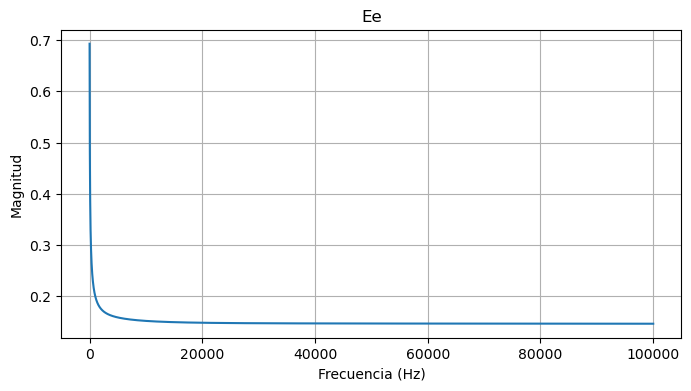

Precisión del clasificador en test: 96.15%
Predicciones en test: Counter({1: 14, 0: 12})
Etiquetas reales: Counter({0: 13, 1: 13})


In [271]:
# Preparar los datos (X = alpha, y = etiquetas binarias: 1 si saxofón, 0 si no)
X = np.concatenate((alpha[68:136],alpha[68*2:]))
y_all = np.array([1 if label == 1 else 0 for label in np.concatenate((y[68:136], y[68*2:]))])

indices = np.arange(68)
np.random.shuffle(indices)  # Mezcla los índices
X[:68] = X[indices]
y_all[:68] = y_all[indices]
X[68:] = X[68+indices]
y_all[68:] = y_all[68+indices]
# 80% entrenamiento, 20% test
split_index = int(0.75 * len(X))
indice_train = 55
split_index = np.concatenate((np.arange(0,indice_train),np.arange(68,68+indice_train)))
index_test = np.concatenate((np.arange(indice_train,68),np.arange(68+indice_train,68*2)))

X_train = X[split_index]
y_train = y_all[split_index]
X_test = X[index_test]
y_test = y_all[index_test]
#
#
indices = np.arange(len(X_train))
np.random.shuffle(indices)  # Mezcla los índices
#print(indices)
# Aplicamos la mezcla a ambos
X_train = X_train[indices]
y_train = y_train[indices]
#
#
indices = np.arange(len(X_test))
np.random.shuffle(indices)  # Mezcla los índices
#print(indices)
#
## Aplicamos la mezcla a ambos
X_test = X_test[indices]
y_test = y_test[indices]
#
# Inicializar pesos y sesgo
weights = np.zeros(X.shape[1])
bias = 0

# Parámetros del modelo
learning_rate = 0.75
epochs = 100000
loss = np.zeros(epochs)

# Entrenamiento
for epoch in range(epochs):
    linear_model = np.dot(X_train, weights) + bias      # z = W*x+b
    y_pred = sigmoid(linear_model)                      # a = g(z)
    
    # Gradientes
    dw = np.dot(X_train.T, (y_pred - y_train)) / y_train.size
    db = np.sum(y_pred - y_train) / y_train.size
    
    # Actualización
    weights -= learning_rate * dw
    bias -= learning_rate * db
    #print(f"y train {epoch}",y_train)
    #print(f"y pred{epoch}",y_pred)
    # Mostrar pérdida
    loss[epoch] = log_loss(y_train,y_pred)
    if epoch - epochs+1 == 0:
        lossy = log_loss(y_train, y_pred)
        print(f'Época {epoch}, Pérdida: {lossy:.4f}')

def error(loss,i):
    return loss[i-1]-loss[i]

plt.figure(figsize=(8, 4))
eje = np.arange(epochs)
plt.plot(eje,loss)
plt.title(f"Ee")
plt.xlabel("Frecuencia (Hz)")
plt.ylabel("Magnitud")
plt.grid(True)
plt.show()

# Evaluación en test
y_pred_test = sigmoid(np.dot(X_test, weights) + bias)
y_pred_class_test = [1 if i > 0.5 else 0 for i in y_pred_test]

accuracy = np.mean(y_pred_class_test == y_test)
print(f'Precisión del clasificador en test: {accuracy * 100:.2f}%')
from collections import Counter
print("Predicciones en test:", Counter(y_pred_class_test))
print("Etiquetas reales:", Counter(y_test))

C:\Users\USUARIO\AppData\Local\Temp\ipykernel_7900\3063727931.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('coolwarm', 2)


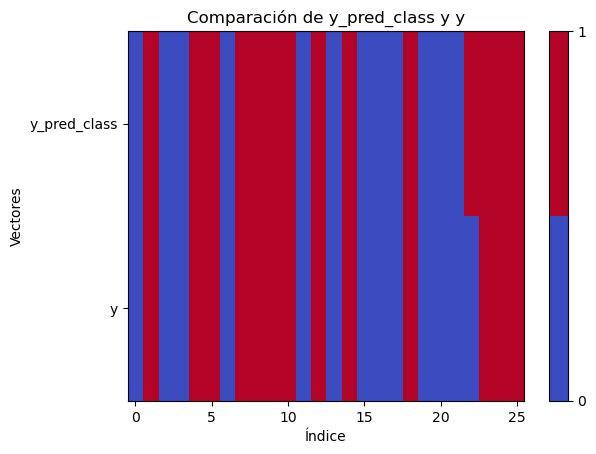

In [272]:
# Crear una cuadrícula para visualizar los vectores
grid = np.zeros((2, len(y_pred_class_test)))

# Asignar los valores a la cuadrícula
grid[0, :] = y_pred_class_test
grid[1, :] = y_test

# Crear un mapa de colores
cmap = plt.cm.get_cmap('coolwarm', 2)

# Graficar la cuadrícula
plt.imshow(grid, cmap=cmap, aspect='auto')

# Etiquetas y título
plt.title('Comparación de y_pred_class y y')
plt.xlabel('Índice')
plt.ylabel('Vectores')
plt.yticks([0, 1], ['y_pred_class', 'y'])

# Barra de color
cbar = plt.colorbar(ticks=[0, 1])
cbar.ax.set_yticklabels(['0', '1'])

# Mostrar la gráfica
plt.show()

## Softmax

### Entrenamiento

Entrenamiento del modelo:
Época 0, Pérdida (entrenamiento): 1.0976, Norma de diferencia de pesos: 2.0000
Época 100, Pérdida (entrenamiento): 0.7971, Norma de diferencia de pesos: 0.0047
Época 200, Pérdida (entrenamiento): 0.7680, Norma de diferencia de pesos: 0.0019
Época 300, Pérdida (entrenamiento): 0.7576, Norma de diferencia de pesos: 0.0011
Época 400, Pérdida (entrenamiento): 0.7527, Norma de diferencia de pesos: 0.0007
Época 500, Pérdida (entrenamiento): 0.7500, Norma de diferencia de pesos: 0.0005
Época 600, Pérdida (entrenamiento): 0.7484, Norma de diferencia de pesos: 0.0004
Época 700, Pérdida (entrenamiento): 0.7474, Norma de diferencia de pesos: 0.0003
Época 800, Pérdida (entrenamiento): 0.7468, Norma de diferencia de pesos: 0.0002
Época 900, Pérdida (entrenamiento): 0.7463, Norma de diferencia de pesos: 0.0002
Época 1000, Pérdida (entrenamiento): 0.7459, Norma de diferencia de pesos: 0.0002
Época 1100, Pérdida (entrenamiento): 0.7456, Norma de diferencia de pesos: 0.0001
Ép

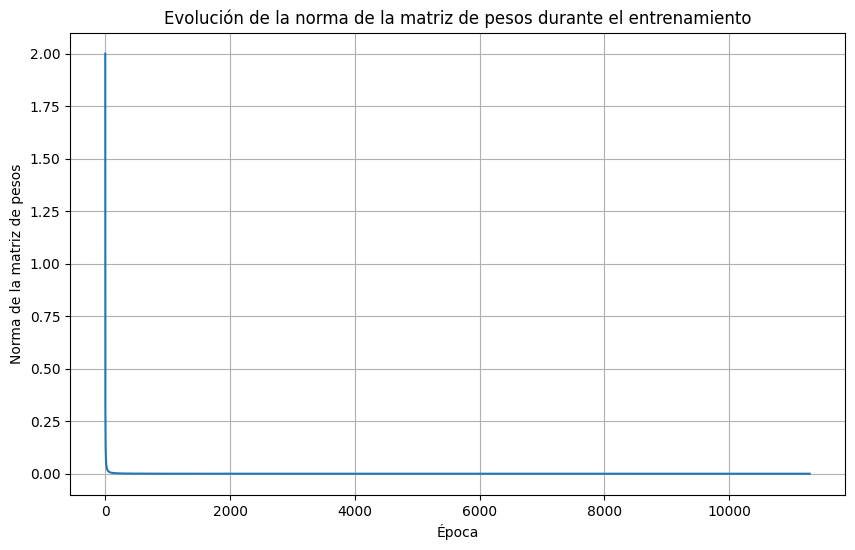

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# Función softmax
def softmax(z):
    exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
    return exp_z / np.sum(exp_z, axis=1, keepdims=True)

# Función de pérdida de entropía cruzada categórica
def categorical_cross_entropy(y_true, y_pred):
    n = y_true.shape[0]
    epsilon = 1e-15
    y_pred_clipped = np.clip(y_pred, epsilon, 1 - epsilon)
    loss = -np.sum(y_true * np.log(y_pred_clipped)) / n
    return loss

# Datos de ejemplo (asumiendo que 'alpha' y 'y' están definidos)
X = np.array(alpha[:])
y_original = y[:]
num_classes = 3

# Convertir las etiquetas a codificación one-hot
def to_one_hot(y, num_classes):
    one_hot = np.zeros((len(y), num_classes))
    for i, label in enumerate(y):
        one_hot[i, int(label)] = 1
    return one_hot

y_one_hot = to_one_hot(y_original, num_classes)

# Dividir los datos manualmente
np.random.seed(42)
indices = np.arange(X.shape[0])
np.random.shuffle(indices)
split_index = int(0.8 * X.shape[0])
train_indices = indices[:split_index]
test_indices = indices[split_index:]

X_train = X[train_indices]
y_train_one_hot = y_one_hot[train_indices]
y_train_original = y_original[train_indices]

X_test = X[test_indices]
y_test_one_hot = y_one_hot[test_indices]
y_test_original = y_original[test_indices]

# Inicializar pesos y sesgos con valores aleatorios
num_features = X_train.shape[1]#num_armonicos
weights = np.random.normal(0, 0.01, (num_features, num_classes)) # Media 0, varianza pequeña (sigma=0.01)
biases = np.zeros(num_classes)

# Parámetros de entrenamiento
learning_rate = 1.3
max_epochs = 100000 # Un límite máximo para evitar bucles infinitos
tolerance = 1e-5
weights_history_norm = []

# Entrenamiento del modelo
relative_diff =2
print("Entrenamiento del modelo:")
previous_weights = weights.copy()
for epoch in range(max_epochs):
    # Calcular las salidas lineales para el conjunto de entrenamiento
    linear_model_train = np.dot(X_train, weights) + biases
    y_pred_probs_train = softmax(linear_model_train)

    # Calcular el gradiente y actualizar los parámetros
    dw = np.dot(X_train.T, (y_pred_probs_train - y_train_one_hot)) / X_train.shape[0]
    db = np.sum(y_pred_probs_train - y_train_one_hot, axis=0) / X_train.shape[0]
    weights -= learning_rate * dw
    biases -= learning_rate * db

    # Calcular la norma de la matriz de pesos
    weights_norm = np.linalg.norm(weights)

    # Comprobar la condición de parada
    if epoch > 0:
        weight_diff_norm = np.linalg.norm(weights - previous_weights)
        relative_diff = weight_diff_norm / np.linalg.norm(weights) if np.linalg.norm(weights) > 0 else print("ERROR: ",weight_diff_norm)
        if relative_diff < tolerance:
            print(f'Entrenamiento detenido en la época {epoch} debido a convergencia.')
            break
    previous_weights = weights.copy()
    weights_history_norm.append(relative_diff)


    if epoch % 100 == 0:
        loss_train = categorical_cross_entropy(y_train_one_hot, y_pred_probs_train)
        print(f'Época {epoch}, Pérdida (entrenamiento): {loss_train:.4f}, Norma de diferencia de pesos: {relative_diff:.4f}')

# Evaluación en el conjunto de prueba
print("\nEvaluación en el conjunto de prueba:")
linear_model_test = np.dot(X_test, weights) + biases
y_pred_probs_test = softmax(linear_model_test)
y_pred_class_test = np.argmax(y_pred_probs_test, axis=1)

# Calcular la precisión en el conjunto de prueba
accuracy_test = np.mean(y_pred_class_test == y_test_original)
print(f'Precisión en el conjunto de prueba: {accuracy_test * 100:.2f}%')

# También podemos calcular la pérdida en el conjunto de prueba (opcional)
loss_test = categorical_cross_entropy(y_test_one_hot, y_pred_probs_test)
print(f'Pérdida en el conjunto de prueba: {loss_test:.4f}')

# Graficar la norma de los pesos a lo largo del entrenamiento
plt.figure(figsize=(10, 6))
plt.plot((weights_history_norm))
plt.xlabel('Época')
plt.ylabel('Norma de la matriz de pesos')
plt.title('Evolución de la norma de la matriz de pesos durante el entrenamiento')
plt.grid(True)
plt.show()

### Vista


Visualización de predicciones y etiquetas verdaderas en dos filas con mapa de colores:


C:\Users\USUARIO\AppData\Local\Temp\ipykernel_7900\2566298280.py:48: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


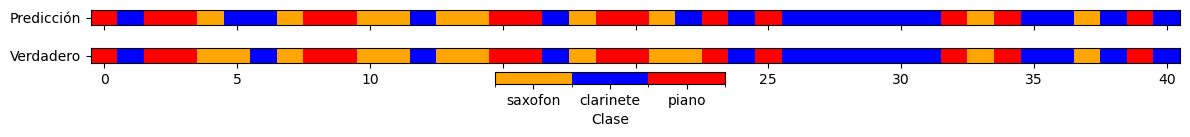


Interpretación de la visualización con mapa de colores en dos filas:
- La fila superior muestra las clases predichas para cada muestra del conjunto de prueba.
- La fila inferior muestra las etiquetas verdaderas correspondientes.
- Cada columna representa una muestra diferente.
- El color indica la clase (naranja: saxofón, azul: clarinete, rojo: piano).
- Comparando verticalmente entre las dos filas, puedes identificar las predicciones correctas e incorrectas.
- La leyenda de las clases se encuentra en la parte inferior.


In [333]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.cm as cm

# ... (Tu código anterior de softmax, datos, entrenamiento, evaluación) ...

# --- Nueva sección para visualización en matriz de dos filas ---
print("\nVisualización de predicciones y etiquetas verdaderas en dos filas con mapa de colores:")

# Obtener las predicciones del conjunto de prueba
linear_model_test = np.dot(X_test, weights) + biases
y_pred_probs_test = softmax(linear_model_test)
y_pred_class_test = np.argmax(y_pred_probs_test, axis=1)

# Número de muestras en el conjunto de prueba
n_test_samples = len(y_test_original)

# Definir los colores para cada clase
class_names = ['saxofon', 'clarinete', 'piano']
class_colors = ['orange', 'blue', 'red']
cmap = ListedColormap(class_colors)
bounds = np.arange(num_classes + 1) - 0.5
norm = plt.matplotlib.colors.BoundaryNorm(bounds, cmap.N)

# Crear la figura con dos subplots (2 filas, 1 columna)
fig, axes = plt.subplots(2, 1, figsize=(12, 1), sharex=True)

# Mostrar las predicciones
im1 = axes[0].imshow([y_pred_class_test], cmap=cmap, aspect='auto', norm=norm)
axes[0].set_yticks([0])
axes[0].set_yticklabels(['Predicción'])
#axes[0].set_title('Clases Predichas')

# Mostrar las etiquetas verdaderas
im2 = axes[1].imshow([y_test_original], cmap=cmap, aspect='auto', norm=norm)
axes[1].set_yticks([0])
axes[1].set_yticklabels(['Verdadero'])
#axes[1].set_title('Clases Verdaderas')
#axes[1].set_xlabel('Índice de la muestra en el conjunto de prueba')
axes[1].set_xlabel('                                    ')

# Añadir una barra de color común a toda la figura en la parte inferior
cbar = fig.colorbar(cm.ScalarMappable(cmap=cmap, norm=norm), ax=axes, ticks=np.arange(num_classes), format='%d', orientation='horizontal', pad=0.2)
cbar.ax.set_xticklabels(class_names)
cbar.set_label('Clase')

plt.tight_layout()
plt.show()

print("\nInterpretación de la visualización con mapa de colores en dos filas:")
print("- La fila superior muestra las clases predichas para cada muestra del conjunto de prueba.")
print("- La fila inferior muestra las etiquetas verdaderas correspondientes.")
print("- Cada columna representa una muestra diferente.")
print("- El color indica la clase (naranja: saxofón, azul: clarinete, rojo: piano).")
print("- Comparando verticalmente entre las dos filas, puedes identificar las predicciones correctas e incorrectas.")
print("- La leyenda de las clases se encuentra en la parte inferior.")
